# Driver Behavior Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wandb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [3]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [4]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [5]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

In [6]:
data = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(data)):
    data[i] = data[i].drop(cols, axis=1, inplace=False)

Plotting different sensors to see the difference

In [7]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not 'sem_evento'
    highlight_color = 'lightgrey'  # Use the same color for all events

    for i in range(len(data) - 1):
        if data['evento'].iloc[i] != 'sem_evento':
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], 
                        alpha=0.3, color=highlight_color, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()


In [ ]:
plot_sensor_data(df_21, 'giroscopio', figsize=(25, 4), begin=0, end=50)

### Sliding Windows

In [7]:
def get_features(window):
    # Features such as mean, max, min and std from the window
    features = np.array([])
    features = np.append(features, [window.mean(), window.max(), window.min(), window.std(), window.max() - window.min()])
    return features

In [60]:
def create_sliding_windows(data, window_size=7, step_size=1, output_3d=False):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array

    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns

            if not output_3d:
                features = get_features(window)

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order


            if not output_3d:
                window = np.append(window.to_numpy().flatten(), features)
            else:
                window = np.array(window)
            
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [9]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [10]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test  

In [11]:
window_size = 7
step_size = 1
X, y = create_sliding_windows(data, window_size, step_size) # This will create the sliding windows with a 3D X and 1D y
X.shape, y.shape

((10663, 108), (10663,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets

In [13]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [14]:
classes = np.unique(y_train)
one_hot = {}
for i in range(len(classes)):
    one_hot[classes[i]] = i
y_train_one_hot = np.array([one_hot[i] for i in y_train])
y_test_one_hot = np.array([one_hot[i] for i in y_test])
one_hot

{'aceleracao_agressiva': 0,
 'curva_direita_agressiva': 1,
 'curva_esquerda_agressiva': 2,
 'evento_nao_agressivo': 3,
 'freada_agressiva': 4,
 'troca_faixa_direita_agressiva': 5,
 'troca_faixa_esquerda_agressiva': 6}

Veryfing the balance of the split

In [15]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))

Train set: {'aceleracao_agressiva': 1716, 'curva_direita_agressiva': 1495, 'curva_esquerda_agressiva': 1515, 'evento_nao_agressivo': 1964, 'freada_agressiva': 1081, 'troca_faixa_direita_agressiva': 440, 'troca_faixa_esquerda_agressiva': 319}
Test set: {'aceleracao_agressiva': 414, 'curva_direita_agressiva': 387, 'curva_esquerda_agressiva': 365, 'evento_nao_agressivo': 480, 'freada_agressiva': 309, 'troca_faixa_direita_agressiva': 94, 'troca_faixa_esquerda_agressiva': 84}


# Machine Learning

First, let's try directly applying a RF algorithm using a single drive to see what happens

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
reports = {}

## Random Forest Classifier

Creating and training the classifier

In [19]:
def fit_RF(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

Model Fitting

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, verbose=5, n_jobs=-1)
best_params_rf = grid_search.fit(X_train_scaled, y_train).best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END ...................n_estimators=50;, score=0.933 total time=   3.5s
[CV 3/5] END ...................n_estimators=50;, score=0.944 total time=   4.2s
[CV 1/5] END ...................n_estimators=50;, score=0.934 total time=   4.8s
[CV 5/5] END ...................n_estimators=50;, score=0.950 total time=   5.1s
[CV 2/5] END ...................n_estimators=50;, score=0.949 total time=   5.1s
[CV 1/5] END ..................n_estimators=100;, score=0.937 total time=  10.8s
[CV 3/5] END ..................n_estimators=100;, score=0.949 total time=  11.2s
[CV 2/5] END ..................n_estimators=100;, score=0.953 total time=  11.4s
[CV 4/5] END ..................n_estimators=100;, score=0.943 total time=  12.9s
[CV 5/5] END ..................n_estimators=100;, score=0.954 total time=  13.1s
[CV 2/5] END ..................n_estimators=200;, score=0.953 total time=  27.3s
[CV 1/5] END ..................n_estimators=200;,

In [21]:
# Non scaled data
print(best_params_rf)
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test, **best_params_rf)
reports['Random Forest'] = report

{'n_estimators': 300}


In [22]:
print(f"Classification report:\n{report}")

Classification report:
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.98      0.96       414
       curva_direita_agressiva       0.96      1.00      0.98       387
      curva_esquerda_agressiva       0.98      0.99      0.99       365
          evento_nao_agressivo       0.93      0.94      0.94       480
              freada_agressiva       0.99      0.95      0.97       309
 troca_faixa_direita_agressiva       1.00      0.84      0.91        94
troca_faixa_esquerda_agressiva       0.99      0.82      0.90        84

                      accuracy                           0.96      2133
                     macro avg       0.97      0.93      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133



In [23]:
def display_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

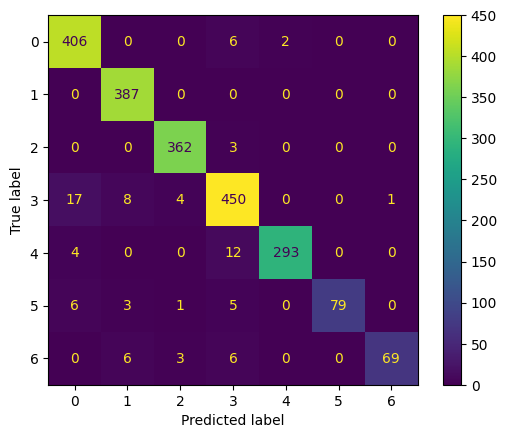

In [24]:
display_cm(y_test, y_pred)

Clearly, scaling the data does not seem to help the Random Forest Classifier

## SVC (Support Vector Classifier)

In [25]:
from sklearn.svm import SVC

In [26]:
def fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.1, kernel='rbf'):
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, classification_report(y_test, y_pred), y_pred

Hyperparameter search

In [27]:
param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']} # Defining the hyperparameters to be tested

In [28]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=3, n_jobs=-1) # Creating the GridSearchCV object
grid_search.fit(X_train_scaled, y_train) # Fitting the model
best_params_svc = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   5.8s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.879 total time=   6.5s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.908 total time=   8.3s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.902 total time=  10.1s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.883 total time=  10.6s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.926 total time=  12.5s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.821 total time=  23.7s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.826 total time=  23.9s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.936 total time=  14.9s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.803 total time=  25.7s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.807 total time=  27.8s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;,

In [29]:
print(best_params_svc)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


Best parameters for the SVC are C: 100, gamma: 0.01, kernel: rbf

Model training

In [30]:
svc_model, svc_report, y_svc_pred = fit_SVC(X_train_scaled, X_test_scaled, y_train, y_test, **best_params_svc)
print(f"Classification report (SVC scaled):\n{svc_report}")
reports['SVC'] = svc_report

svc_model_scaled, svc_report_scaled, y_svc_pred_scaled = fit_SVC(X_train, X_test, y_train, y_test, **best_params_svc)
print(f"Classification report (SVC non-scaled):\n{svc_report_scaled}")

Classification report (SVC scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.94      0.94       414
       curva_direita_agressiva       0.97      1.00      0.98       387
      curva_esquerda_agressiva       0.99      0.98      0.99       365
          evento_nao_agressivo       0.91      0.94      0.92       480
              freada_agressiva       1.00      0.94      0.97       309
 troca_faixa_direita_agressiva       0.98      0.94      0.96        94
troca_faixa_esquerda_agressiva       0.91      0.85      0.88        84

                      accuracy                           0.96      2133
                     macro avg       0.96      0.94      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133

Classification report (SVC non-scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.89      0.90     

SVC works better with scaled data

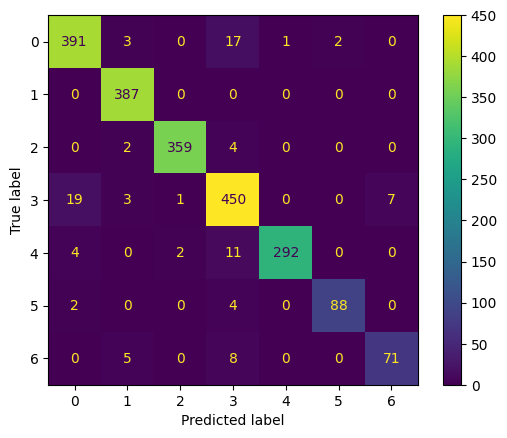

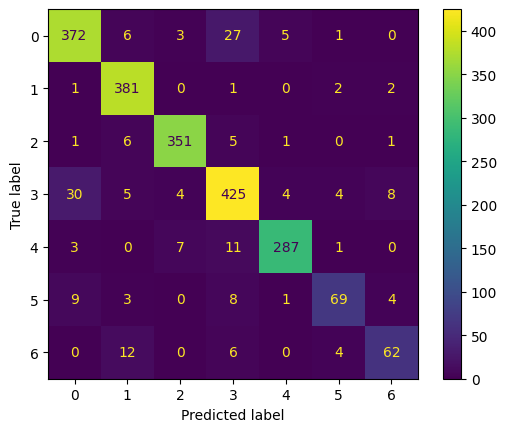

In [31]:
display_cm(y_test, y_svc_pred)
display_cm(y_test, y_svc_pred_scaled)

## XGBoost

In [32]:
from xgboost import XGBClassifier

In [33]:
def fit_XGB(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=4):
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred, target_names=list(one_hot.keys())), y_pred

In [34]:
xgb_model, xgb_report, y_pred_xgb = fit_XGB(X_train_scaled, X_test_scaled, y_train_one_hot, y_test_one_hot, n_estimators=300, max_depth=3)
reports['XGB'] = xgb_report
print(f"**Classification report (XGB):**\n{xgb_report}")

**Classification report (XGB):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.97      0.99      0.98       414
       curva_direita_agressiva       0.99      1.00      0.99       387
      curva_esquerda_agressiva       0.99      0.99      0.99       365
          evento_nao_agressivo       0.98      0.97      0.98       480
              freada_agressiva       1.00      0.99      0.99       309
 troca_faixa_direita_agressiva       0.99      0.93      0.96        94
troca_faixa_esquerda_agressiva       0.98      0.94      0.96        84

                      accuracy                           0.98      2133
                     macro avg       0.98      0.97      0.98      2133
                  weighted avg       0.98      0.98      0.98      2133



# MLP Scikit-Learn

In [35]:
from sklearn.neural_network import MLPClassifier

In [36]:
def fit_MLP(X_train, X_test, y_train, y_test, hidden_layer_sizes=(100, 50, 25), max_iter=1000, activation='relu', solver='adam'):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation=activation, solver=solver)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred), y_pred

In [37]:
mlp, mlp_scikit_report, y_pred_mlp = fit_MLP(X_train_scaled, X_test_scaled, y_train, y_test, hidden_layer_sizes=(500, 250, 100, 50), max_iter=2000, activation='relu', solver='adam')
reports['MLP_Scikit'] = mlp_scikit_report
print(f"**Classification report (MLP):**\n{mlp_scikit_report}")

**Classification report (MLP):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.96      0.98      0.97       414
       curva_direita_agressiva       0.99      0.99      0.99       387
      curva_esquerda_agressiva       0.99      1.00      0.99       365
          evento_nao_agressivo       0.95      0.94      0.95       480
              freada_agressiva       1.00      0.99      0.99       309
 troca_faixa_direita_agressiva       0.98      0.89      0.93        94
troca_faixa_esquerda_agressiva       0.90      0.92      0.91        84

                      accuracy                           0.97      2133
                     macro avg       0.97      0.96      0.96      2133
                  weighted avg       0.97      0.97      0.97      2133



# MLP TensorFlow

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, BatchNormalization, LSTM
from tensorflow.keras.utils import to_categorical

Using categorial crossentropy since the labels are one-hot encoded

In [27]:
def create_model(opmitizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    model =  Sequential([
        # Input is of shape (number_of_features,)
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(500, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(250, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(100, activation='relu'),
        BatchNormalization(),

        Dense(50, activation='relu'),
        BatchNormalization(),

        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=opmitizer, loss=loss, metrics=metrics)
    return model

In [18]:
def resultados_modelo(historico):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()

    ax[0].plot(historico.history['accuracy'], label='Accuracy', marker='o', color='red')
    ax[0].plot(historico.history['val_accuracy'], label='Val_Accuracy', marker='o', color='blue')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(historico.history['loss'], label='Loss', marker='o', color='red')
    ax[1].plot(historico.history['val_loss'], label='Val_Loss', marker='o', color='blue')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    for i in range(2):
        ax[i].legend()
        ax[i].grid()

    acc_size =len(historico.history["accuracy"]) - 1
    print(f'Acurácia final: {round(100 * historico.history["accuracy"][acc_size], 3)}%')
    loss_size =len(historico.history["loss"]) - 1
    print(f'Loss final: {round(100 * historico.history["loss"][loss_size], 3)}%')

In [19]:
def train_mlp_wandb():
    wandb.init(project='DriverBehavior')
    epochs = wandb.config.epochs
    batch_size = wandb.config.batch_size

    model = create_model()
    history = model.fit(X_train_scaled, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_one_hot))

    wandb.log({
        'train_loss': history.history['loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
    })

In [66]:
sweep_config = {
    'method': 'grid',  # 'random' or 'bayes' for other strategies
    'metric': {
        'name': 'val_accuracy',  # The metric to optimize
        'goal': 'maximize'  # Maximize or minimize the metric
    },
    'parameters': {
        'epochs': {
            'values': [10, 25, 50]  # Range of epochs to test
        },
        'batch_size': {
            'values': [32, 64, 128]  # Range of batch sizes to test
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="DriverBehavior")

Create sweep with ID: gut8lurp
Sweep URL: https://wandb.ai/renan-florencio-unicamp/DriverBehavior/sweeps/gut8lurp


In [67]:
wandb.agent(sweep_id, train_mlp_wandb, count=10)

wandb: Agent Starting Run: wa0u51qj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5708 - loss: 1.2386 - val_accuracy: 0.8401 - val_loss: 0.5023
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8150 - loss: 0.5633 - val_accuracy: 0.8790 - val_loss: 0.3666
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8610 - loss: 0.4236 - val_accuracy: 0.8955 - val_loss: 0.3012
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8725 - loss: 0.3591 - val_accuracy: 0.9072 - val_loss: 0.2684
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9073 - loss: 0.2814 - val_accuracy: 0.9198 - val_loss: 0.2360
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9137 - loss: 0.2591 - val_accuracy: 0.9287 - val_loss: 0.2208
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9217 - loss: 0.2276 - val_accuracy: 0.9259 - val_loss: 0.2389
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9198 - loss: 0.2255 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93916
train_loss,0.16933
val_accuracy,0.94374
val_loss,0.18658


wandb: Agent Starting Run: syfu5ppp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25


Epoch 1/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5613 - loss: 1.2509 - val_accuracy: 0.8242 - val_loss: 0.4856
Epoch 2/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7947 - loss: 0.5854 - val_accuracy: 0.8837 - val_loss: 0.3256
Epoch 3/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8523 - loss: 0.4223 - val_accuracy: 0.9058 - val_loss: 0.2773
Epoch 4/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8811 - loss: 0.3343 - val_accuracy: 0.9147 - val_loss: 0.2575
Epoch 5/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8941 - loss: 0.2991 - val_accuracy: 0.9287 - val_loss: 0.2127
Epoch 6/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9177 - loss: 0.2408 - val_accuracy: 0.9203 - val_loss: 0.2294
Epoch 7/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9186 - loss: 0.2467 - val_accuracy: 0.9405 - val_loss: 0.1954
Epoch 8/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9275 - loss: 0.2100 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97257
train_loss,0.08191
val_accuracy,0.9564
val_loss,0.15545


wandb: Agent Starting Run: 0kvkdc3y with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50


Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5555 - loss: 1.2769 - val_accuracy: 0.8448 - val_loss: 0.4363
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8036 - loss: 0.5645 - val_accuracy: 0.8865 - val_loss: 0.3532
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8524 - loss: 0.4331 - val_accuracy: 0.9095 - val_loss: 0.2760
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8849 - loss: 0.3425 - val_accuracy: 0.9208 - val_loss: 0.2443
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9013 - loss: 0.2916 - val_accuracy: 0.9325 - val_loss: 0.1940
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9119 - loss: 0.2587 - val_accuracy: 0.9339 - val_loss: 0.1879
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9281 - loss: 0.2251 - val_accuracy: 0.9311 - val_loss: 0.2079
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9329 - loss: 0.2002 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.05015
val_accuracy,0.96906
val_loss,0.14908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d08g61w2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5378 - loss: 1.3229 - val_accuracy: 0.8411 - val_loss: 0.4789
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7916 - loss: 0.6135 - val_accuracy: 0.8800 - val_loss: 0.3742
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8456 - loss: 0.4658 - val_accuracy: 0.8940 - val_loss: 0.3051
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8715 - loss: 0.3706 - val_accuracy: 0.9142 - val_loss: 0.2714
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8868 - loss: 0.3160 - val_accuracy: 0.9194 - val_loss: 0.2285
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9072 - loss: 0.2706 - val_accuracy: 0.9264 - val_loss: 0.2345
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9097 - loss: 0.2654 - val_accuracy: 0.9269 - val_loss: 0.2283
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9226 - loss: 0.2317 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.9381
train_loss,0.18065
val_accuracy,0.93812
val_loss,0.20765


wandb: Agent Starting Run: 3znzxxqe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25


Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5303 - loss: 1.3739 - val_accuracy: 0.8284 - val_loss: 0.4927
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7891 - loss: 0.6302 - val_accuracy: 0.8861 - val_loss: 0.3421
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.4627 - val_accuracy: 0.9062 - val_loss: 0.2701
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8704 - loss: 0.3736 - val_accuracy: 0.9128 - val_loss: 0.2540
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8964 - loss: 0.3067 - val_accuracy: 0.9353 - val_loss: 0.2168
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9021 - loss: 0.2856 - val_accuracy: 0.9301 - val_loss: 0.2212
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9150 - loss: 0.2466 - val_accuracy: 0.9344 - val_loss: 0.1897
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9222 - loss: 0.2165 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97304
train_loss,0.08219
val_accuracy,0.95499
val_loss,0.1595


wandb: Agent Starting Run: fp4pjgab with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5314 - loss: 1.3547 - val_accuracy: 0.8383 - val_loss: 0.4747
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7909 - loss: 0.6286 - val_accuracy: 0.8758 - val_loss: 0.3519
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8467 - loss: 0.4483 - val_accuracy: 0.8987 - val_loss: 0.3067
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8765 - loss: 0.3713 - val_accuracy: 0.9137 - val_loss: 0.2837
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8964 - loss: 0.3163 - val_accuracy: 0.9142 - val_loss: 0.2376
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9013 - loss: 0.2960 - val_accuracy: 0.9241 - val_loss: 0.2351
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9158 - loss: 0.2411 - val_accuracy: 0.9241 - val_loss: 0.2200
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9256 - loss: 0.2233 - val_accur

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98124
train_loss,0.05425
val_accuracy,0.97609
val_loss,0.12793


wandb: Agent Starting Run: x95rt9bq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4989 - loss: 1.4532 - val_accuracy: 0.8228 - val_loss: 0.5362
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7661 - loss: 0.6764 - val_accuracy: 0.8664 - val_loss: 0.4044
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8208 - loss: 0.5339 - val_accuracy: 0.8823 - val_loss: 0.3463
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8493 - loss: 0.4353 - val_accuracy: 0.9109 - val_loss: 0.2698
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8760 - loss: 0.3587 - val_accuracy: 0.9072 - val_loss: 0.2831
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8983 - loss: 0.3140 - val_accuracy: 0.9297 - val_loss: 0.2236
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9082 - loss: 0.2759 - val_accuracy: 0.9278 - val_loss: 0.2219
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9108 - loss: 0.2623 - val_accuracy: 0.9409 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93189
train_loss,0.20206
val_accuracy,0.93624
val_loss,0.19907


wandb: Agent Starting Run: huhy15vj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25


Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4712 - loss: 1.5265 - val_accuracy: 0.7979 - val_loss: 0.5860
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7648 - loss: 0.7112 - val_accuracy: 0.8697 - val_loss: 0.3809
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8106 - loss: 0.5406 - val_accuracy: 0.8973 - val_loss: 0.3127
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8418 - loss: 0.4649 - val_accuracy: 0.9090 - val_loss: 0.2755
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8810 - loss: 0.3447 - val_accuracy: 0.9161 - val_loss: 0.2475
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8948 - loss: 0.3079 - val_accuracy: 0.9212 - val_loss: 0.2312
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8988 - loss: 0.2868 - val_accuracy: 0.9348 - val_loss: 0.2044
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9161 - loss: 0.2493 - val_accuracy: 0.9325 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97022
train_loss,0.08487
val_accuracy,0.96296
val_loss,0.13763


wandb: Agent Starting Run: xgjz54bz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4816 - loss: 1.5145 - val_accuracy: 0.8158 - val_loss: 0.5422
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7641 - loss: 0.6851 - val_accuracy: 0.8805 - val_loss: 0.3798
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8205 - loss: 0.5247 - val_accuracy: 0.8973 - val_loss: 0.3135
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8611 - loss: 0.4233 - val_accuracy: 0.9067 - val_loss: 0.2720
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8782 - loss: 0.3567 - val_accuracy: 0.9203 - val_loss: 0.2335
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8902 - loss: 0.3233 - val_accuracy: 0.9198 - val_loss: 0.2284
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9071 - loss: 0.2794 - val_accuracy: 0.9339 - val_loss: 0.1972
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9188 - loss: 0.2312 - val_accuracy: 0.9395 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.04612
val_accuracy,0.97656
val_loss,0.10633


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


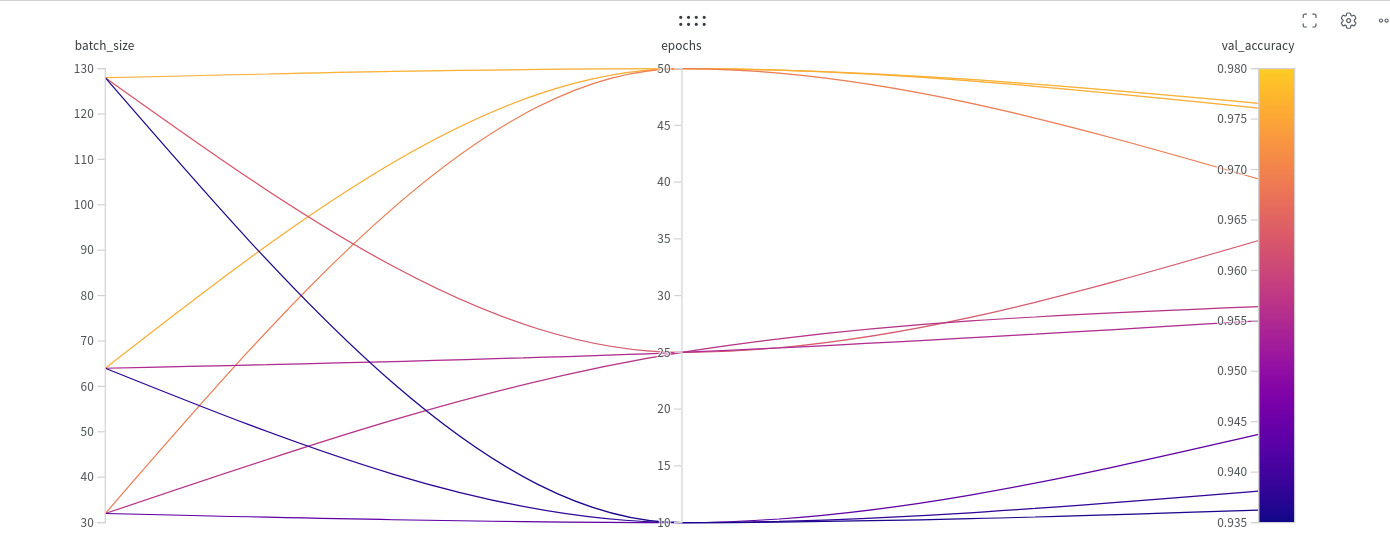

Seems like a batch size of 128 with 50 epochs is optimal for this problem

In [28]:
model = create_model()
history = model.fit(X_train_scaled, y_train_one_hot, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test_one_hot))

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5772 - loss: 1.1967 - val_accuracy: 0.7684 - val_loss: 0.8351
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8301 - loss: 0.4976 - val_accuracy: 0.8880 - val_loss: 0.4332
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8815 - loss: 0.3659 - val_accuracy: 0.9170 - val_loss: 0.2807
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8958 - loss: 0.2931 - val_accuracy: 0.9372 - val_loss: 0.2119
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9077 - loss: 0.2604 - val_accuracy: 0.9409 - val_loss: 0.1778
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9183 - loss: 0.2250 - val_accuracy: 0.9522 - val_loss: 0.1494
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9285 - loss: 0.1968 - val_accuracy: 0.9494 - val_loss: 0.1595
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9338 - loss: 0.1882 - val_accuracy: 0.9461 - v

In [29]:
y_pred_prob = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_prob, axis=1)
report_mlp_tensor = classification_report(y_test_one_hot, y_pred_nn, target_names=list(one_hot.keys()))
# reports['MLP_Tensorflow'] = report_mlp_tensor
print(f"**Classification report (MLP):**\n{report_mlp_tensor}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
**Classification report (MLP):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.97      0.99      0.98       414
       curva_direita_agressiva       0.99      1.00      1.00       387
      curva_esquerda_agressiva       1.00      1.00      1.00       365
          evento_nao_agressivo       0.97      0.97      0.97       480
              freada_agressiva       1.00      0.98      0.99       309
 troca_faixa_direita_agressiva       1.00      0.95      0.97        94
troca_faixa_esquerda_agressiva       0.96      0.93      0.95        84

                      accuracy                           0.98      2133
                     macro avg       0.98      0.97      0.98      2133
                  weighted avg       0.98      0.98      0.98      2133



# LSTM TensorFlow

In [90]:
def create_model_lstm(opmitizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):

    model =  Sequential([

        # LSTMs require a 3D input in the form of (time steps (window_size), features per sample). The batch size is not required and is automatically set by Keras.
        Input(shape=(7, 9)),

        LSTM(100, activation='relu', return_sequences=True), # Keeping the return_sequences=True to stack multiple LSTMs
        BatchNormalization(),

        LSTM(50, activation='relu'),
        BatchNormalization(),

        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(100, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=opmitizer, loss=loss, metrics=metrics)
    return model

Since the LSTM needs the matrix of features for every timestep, it is necessary to recreate the sliding window ignoring the extra features and avoing the flattening of the window

In [111]:
window_size = 7
step_size = 1
X_lstm, y_lstm = create_sliding_windows(data, window_size, step_size, output_3d=True) # This will create the sliding windows with a 3D X and 1D y_lstm
X_lstm.shape, y_lstm.shape

((10663, 7, 9), (10663,))

Now we need to split it into train and test and scale it. To scale the data, we need to flatten it, normalize it and then get it back.

In [117]:
y_lstm_one_hot = [one_hot[i] for i in y_lstm]
y_lstm_one_hot = to_categorical(y_lstm)

In [118]:
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm_one_hot, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets
X_lstm_train_scaled, X_lstm_test_scaled = scale_data(X_lstm_train.reshape(X_lstm_train.shape[0], -1), X_lstm_test.reshape(X_lstm_test.shape[0], -1))
X_lstm_train_scaled = X_lstm_train_scaled.reshape(X_lstm_train.shape)
X_lstm_test_scaled = X_lstm_test_scaled.reshape(X_lstm_test.shape)

Now, one-hot encoding the labels:

In [120]:
lstm = create_model_lstm(loss='categorical_crossentropy')
history_lstm = lstm.fit(X_lstm_train_scaled, y_lstm_train, epochs=50, batch_size=128, validation_data=(X_lstm_test_scaled, y_lstm_test))

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5627 - loss: 1.2643 - val_accuracy: 0.2935 - val_loss: 1.7798
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8444 - loss: 0.4557 - val_accuracy: 0.2916 - val_loss: 1.6968
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8973 - loss: 0.3089 - val_accuracy: 0.3868 - val_loss: 1.4960
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9243 - loss: 0.2343 - val_accuracy: 0.5663 - val_loss: 1.2115
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9311 - loss: 0.1947 - val_accuracy: 0.7379 - val_loss: 0.8053
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9537 - loss: 0.1331 - val_accuracy: 0.8050 - val_loss: 0.5710
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9558 - loss: 0.1289 - val_accuracy: 0.8608 - val_loss: 0.4163
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9658 - loss: 0.1079 - val_accuracy: 0.9241 - v

KeyboardInterrupt: 

In [107]:
y_pred_lstm_prob = lstm.predict(X_lstm_test_scaled)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
report_lstm = classification_report(y_test_one_hot, y_pred_lstm, target_names=list(one_hot.keys()))
# reports['LSTM'] = report_lstm
print(f"**Classification report (LSTM):**\n{report_lstm}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
**Classification report (LSTM):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       1.00      1.00      1.00       414
       curva_direita_agressiva       1.00      1.00      1.00       387
      curva_esquerda_agressiva       0.99      1.00      0.99       365
          evento_nao_agressivo       1.00      0.99      0.99       480
              freada_agressiva       1.00      1.00      1.00       309
 troca_faixa_direita_agressiva       0.99      1.00      0.99        94
troca_faixa_esquerda_agressiva       0.98      1.00      0.99        84

                      accuracy                           1.00      2133
                     macro avg       0.99      1.00      1.00      2133
                  weighted avg       1.00      1.00      1.00      2133



Since the results look too good, let's try cross-validation

In [108]:
from sklearn.model_selection import KFold

In [123]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X_lstm):
    X_train_fold, X_val_fold = X_lstm[train_index], X_lstm[test_index]
    y_train_fold, y_val_fold = y_lstm[train_index], y_lstm[test_index]

    X_train_fold_scaled, X_test_fold_scaled = scale_data(X_train_fold.reshape(X_train_fold.shape[0], -1), X_val_fold.reshape(X_val_fold.shape[0], -1))
    X_train_fold_scaled = X_train_fold_scaled.reshape(X_train_fold.shape)
    X_val_fold_scaled = X_test_fold_scaled.reshape(X_val_fold.shape)

    lstm = create_model_lstm(loss='categorical_crossentropy')
    history_lstm = lstm.fit(X_train_fold_scaled, y_train_fold, epochs=50, batch_size=128, validation_data=(X_val_fold_scaled, y_val_fold))

    val_loss, val_accuracy = lstm.evaluate(X_val_fold_scaled, y_val_fold)
    accuracies.append(val_accuracy)

print(f'Average accuracy: {np.mean(accuracies)}')

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5656 - loss: 1.2679 - val_accuracy: 0.2297 - val_loss: 1.8247
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8590 - loss: 0.4185 - val_accuracy: 0.2363 - val_loss: 1.7811
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8983 - loss: 0.3025 - val_accuracy: 0.2597 - val_loss: 1.6941
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9181 - loss: 0.2352 - val_accuracy: 0.4158 - val_loss: 1.4131
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9448 - loss: 0.1626 - val_accuracy: 0.6409 - val_loss: 0.9802
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9558 - loss: 0.1333 - val_accuracy: 0.7722 - val_loss: 0.6143
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9588 - loss: 0.1211 - val_accuracy: 0.8345 - val_loss: 0.4287
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9669 - loss: 0.0997 - val_accuracy: 0.9095 - v

# Comparing Results

In [44]:
def parse_classification_report(report):
    lines = report.split('\n')
    metrics = []
    accuracy = None
    for line in lines[2:-3]:  # Skip header and last two summary lines
        parts = line.split()
        if len(parts) < 4:
            continue
        class_name = parts[0]
        precision = float(parts[1])
        recall = float(parts[2])
        f1_score = float(parts[3])
        metrics.append((class_name, precision, recall, f1_score))
    
    # Extract accuracy from the summary line
    accuracy_line = lines[-2]  # Last second line for accuracy
    accuracy = float(accuracy_line.split()[-2])  # Accuracy is the second-to-last value

    return metrics, accuracy


In [69]:
def compare_reports(reports):
    # Assuming `reports` is a dictionary of reports from different models
    combined_df = []
    accuracies = {}

    # Iterate through the reports for different models
    for model, report in reports.items():
        print(f"**{model}:**")
        metrics, accuracy = parse_classification_report(report)
        # Create a DataFrame for each model's metrics
        df_model = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score"])
        df_model['Model'] = model
        combined_df.append(df_model)
        accuracies[model] = accuracy  # Store accuracy for the model

    # Concatenate all model DataFrames into a single DataFrame
    combined_df = pd.concat(combined_df, axis=0)

    # Melt the DataFrame to long format for plotting
    melted_df = combined_df.melt(id_vars=['Model', 'Class'], var_name="Metric", value_name="Score")

    # Create subplots for Precision, Recall, F1-Score, and Accuracy
    fig, axes = plt.subplots(4, 1, figsize=(20, 20))

    # Plot Precision
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'Precision'], ax=axes[0])
    axes[0].set_title('Comparison of Models by Precision')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0.8, 1)
    axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Plot Recall
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'Recall'], ax=axes[1])
    axes[1].set_title('Comparison of Models by Recall')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0.8, 1)
    axes[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Plot F1-Score
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'F1-Score'], ax=axes[2])
    axes[2].set_title('Comparison of Models by F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_ylim(0.8, 1)
    axes[2].legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Plot Accuracy (this is a separate bar plot because accuracy is not per class)
    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
    sns.barplot(x='Model', y='Accuracy', data=accuracy_df, ax=axes[3])
    axes[3].set_title('Comparison of Models by Accuracy')
    axes[3].set_xlabel('Model')
    axes[3].set_ylabel('Accuracy')
    axes[3].set_ylim(0.8, 1)
    
    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()
    

**Random Forest:**
**SVC:**
**XGB:**
**MLP_Scikit:**
**MLP_Tensorflow:**


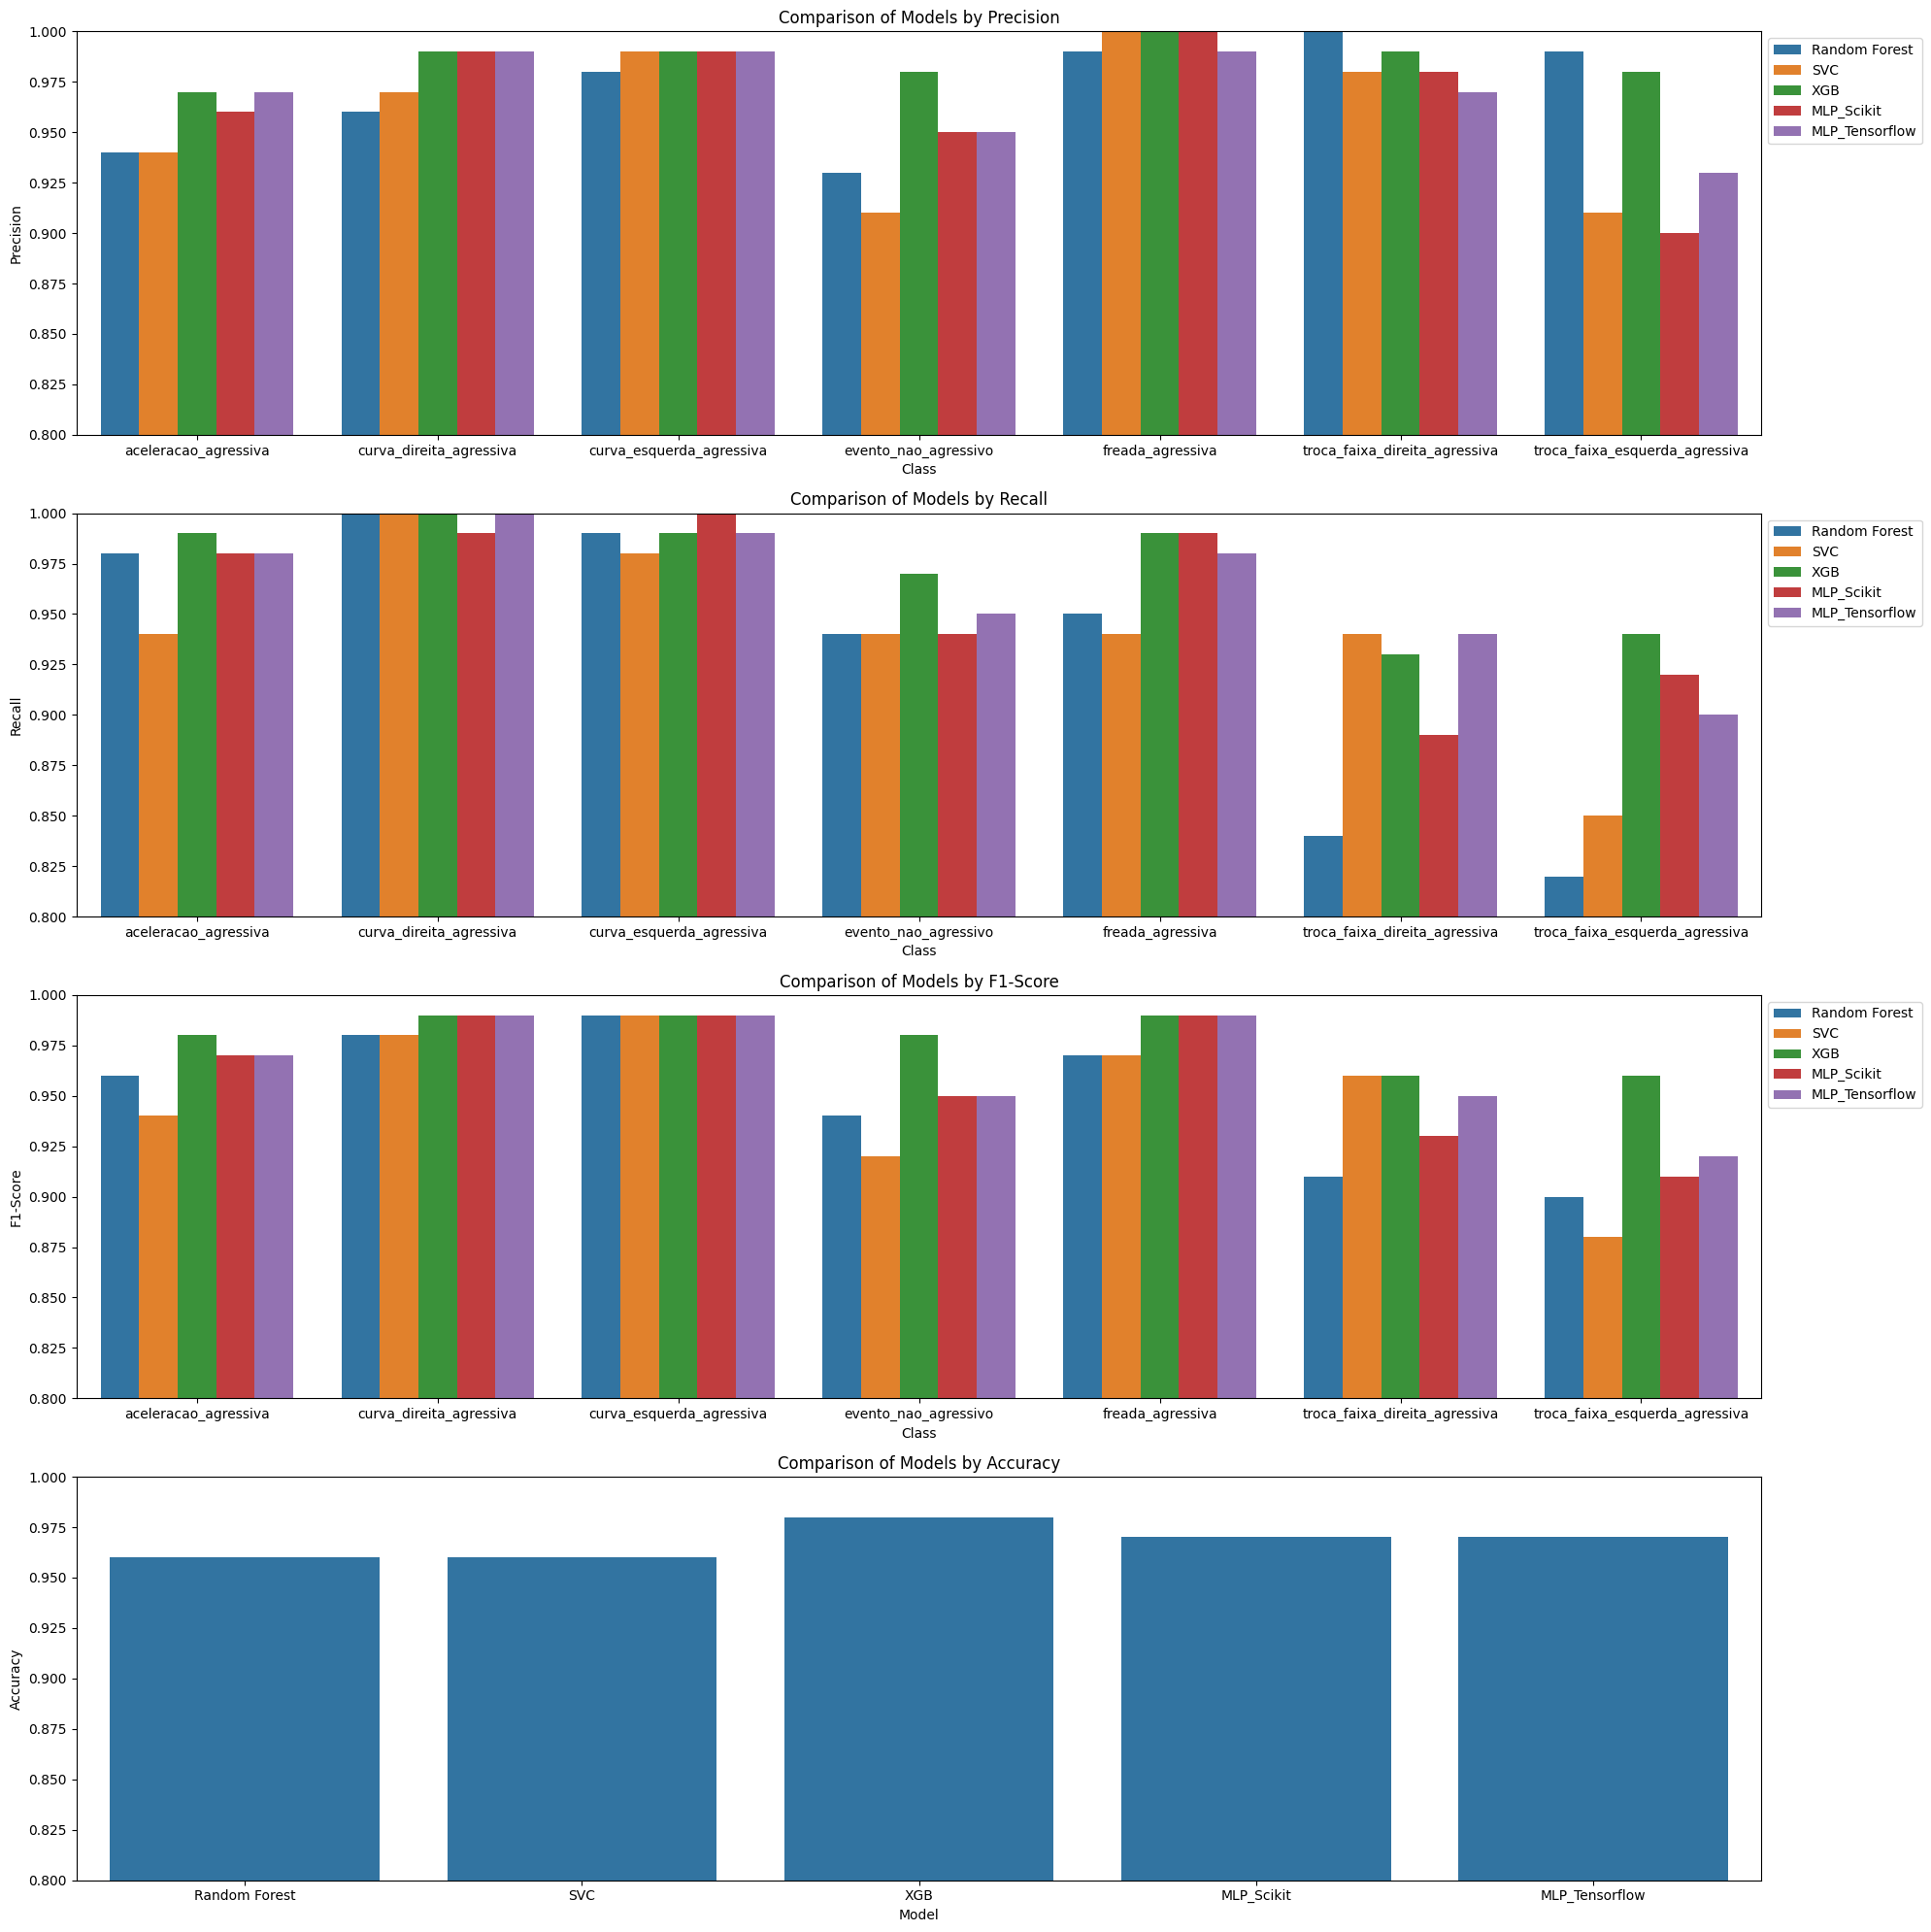

In [70]:
compare_reports(reports)